# Aligned SOMs Implementation Details

**Authors:**   
Markus Kiesel (01228952)   
Alexander Melem(11809621)   
Laurenz Ruzicka (01619916)

## Implementation Details

Aligned SOMs aims at training mulitple layers of n SOMs with differently weighted subsets of attributes.
The implementation of the SOM training is closely modelled after the decription in the paper Aligned self-organizing maps by Pampalk, Elias [[1]](#1). The Alignd SOM implementation uses the well known MiniSom package and trains multiple layers of the MiniSom [[2]](#2). A Layer has in extension to the normal MiniSom implementation the possibility to set initial codebook weights. Furter, the update method is adapted to model the distance between layers. We implemented an online-training algorithm which iteratively traines all layers.

In the follwing sections we will briefly describe the major concepts of the Algind SOM and how we implemented it. We will describe the implementation and effect of the parameters when there is no difference to the normal SOM as implmented in the MiniSom library. All parameters and "public" mehtods of the algorithm have docstrings describing the parameter and method in more detail if some aspects are still unclear from the description.


## Layer Weighting

Two aspects of features in a dataset are differently weightet in different layers of the Alignd SOMs. The first layer uses a weighting ratio between aspect A and aspect B features of 1:0. The middle or center layer, weights both aspects equally. The last layer uses a weighting ratio of 0:1.

We create the weights by layer in the **AlignedSom** class using the method **_create_weights_by_layer**. The **AlignedSom** accepts a parameter **aspect_selection** which has to be a boolean List inidcating if the feature belongs to aspect A (True or 1) or if it belongs to aspect B (False or 0).
The weights of features assigned to aspact A are a linear interpolation of 0 to 1 and the weights of features assinged to aspect B are a linear interpolation from 1 to 0.

## Layer/Codebook inizialization

We create N SOM layers inizializing them identically using the same common codebook but weighting them by the respective layer weight vector. 

The inizialization of the layers in the **AlignedSom** class is done in the method **_create_layers**. The number of layers created can be defined by the parameter **num_layers**. We either crate the common codebook randomly or train the center SOM (trained with unweighted data) and use it as basis for all layer inizializations. This can be changeed by the parameter **codebook_inizialization_type** ("random" or "pretrained").
The weighting of the layers is done by the **weights_by_layer** as explaind in the previous section. One Layer is represented by the **Layer** class which extends the MiniSom algorithm by overwriting the **update** method.

## Training

We train multiple layers of SOMs iteratively with an online-training algorithm. The alogrithm is implemented as follows:
1) select a random layer and a random observation from the dataset
2) select the winning unit in the selected layer based on the weighted feature vector
3) train all layers updating the weights based on the same winning unint
    * the selected layer is updated as in the normal SOM training
    * all other layers update the weights similarly but the update is further influenced by the distance to the selected layer
    * all layers use the weighted feature vector based on their respective layer weights
4) iterate steps 1-3 N times

Instad of directly calling the **train** method of one **Layer** the **AlignedSom** iteratively updates the codebook of differnt layers by calling the **update** method. We archive the updates of the codebook in each **Layer** by changing the **update** method of the MiniSom which now also accepts a parameter **ĺayer_dist** which represents the distance between **Layers** in the stack. 

### Layer distances

The distance of the layers is defined as follows.
* the distance to the layer to iteslf is 1.0 which equals the normal SOM update rule
* the distance to the neighboring layer is a fraction (layer_distance_ratio (default 1/10)) of the distance between neighbooring units in one layer
* the distance is defined by a gaussian function with sigma=1.0

We initailly create the distances between layers in the **AlignedSom** in the method **_create_layer_distances**. We do not reduce the distance between layers during the training time as the neighborhood in one layer because we noticed that neighboring layers would have very different codebook weights.

## Visualization

The visualizations are based on the ones in [PySOMVis](https://github.com/smnishko/PySOMVis). The only change inside the visualizations is that we resize the resulting matrix to get a smoother visualization.   
In the **visualize.py** module the wrapper function **plot_aligned_som** can be used to plot multiple layers of the SOM next to each other. We always show the first and last layer and desired number of SOMs based on the **num_plots** parameter. The type of visualization can be selected by the **visualization_function** parameter. The implemented options are Hit Histogram (**HitHist**), U-Matrix (**UMatrix**) and Smoothed-Data-Histogram (**SDH**) which are all implemented in the same module.


## References
<a id="1">[1]</a>
Pampalk, Elias.
"Aligned self-organizing maps." Proceedings of the Workshop on Self-Organizing Maps. 2003.   
URL: https://www.researchgate.net/publication/2887633_Aligned_Self-Organizing_Maps

<a id="2">[2]</a>
Vettigli, Giuseppe.
"MiniSom: minimalistic and NumPy-based implementation of the Self Organizing Map." (2018).   
URL: https://github.com/JustGlowing/minisom 

In [1]:
import os, sys
import numpy as np
from typing import Tuple, List
from minisom import MiniSom
from random import randrange, seed
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
  sys.path.append(module_path)

from src.data import load_dataset
from src.config import config
from src.visualize import SDH, HitHist, UMatrix

## Implementation of one Layer

In [2]:
class Layer(MiniSom):
    """One layer of the Aligned SOM extending the MiniSom library"""
    def __init__(self,
                 dimension: Tuple[int, int],
                 input_len: int,
                 initial_codebook: np.ndarray,
                 sigma: float = 1.0,
                 learning_rate: float = 0.5,
                 neighborhood_function: str = 'gaussian',
                 activation_distance: str = 'euclidean',
                 random_seed: int = None) -> None:
        """Constructs one layer of the Aligned SOM

        Args:
            dimension (Tuple[int, int]): x and y dimensions of the resulting SOM
            input_len (int): Dimension of the training data
            initial_codebook (np.ndarray): Weight vectors of the initial codebook with dimensions (x, y, input_len)
            sigma (float, optional): Initial spread of the neighborhood function. Defaults to 1.0.
            learning_rate (float, optional): initial Learning rate. Defaults to 0.5.
            neighborhood_function (str, optional):
                Type of function to use for computing the neighborhood.
                Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle'
                Defaults to 'gaussian'.
            activation_distance (str, optional):
                Type of function used for computing the distances between unit weight vectors and feature vectors
                Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
                Defaults to 'euclidean'.
            random_seed (int, optional):
                Random seed used for all operations which use randomness.
                Defaults to None
        """

        super().__init__(
            x=dimension[0],
            y=dimension[1],
            input_len=input_len,
            sigma=sigma,
            learning_rate=learning_rate,
            neighborhood_function=neighborhood_function,
            topology='rectangular',
            activation_distance=activation_distance,
            random_seed=random_seed)

        # after initialization of the weights by MiniSom override them with pre defined codebook
        self._weights = initial_codebook

    # changed update to include the distance to the layer in the neighborhood
    def update(self,
               input_vector: np.array,
               winner_position: Tuple[int, int],
               layer_dist: float,
               time_point: int,
               max_iteration: int) -> None:
        """Update the SOM codebook similar to normal SOM update including the distance between layers
            (extended update function of the MiniSom library)

        Args:
            input_vector (np.array): 1d input vector used for training
            winner_position (Tuple[int, int]): Tuple indicating the position of the winning unit [x, y]
            layer_dist (float):
                fraction representing the distance between layers
                max 1.0 which is normal SOM update for same layer
            time_point (int):
                current number of iteration of the training algorithm used for
                determining the decay of learning rate and neighborhood size
            max_iteration (int):
                number of iterations used for training the map used for
                determining the decay of learning rate and neighborhood size
        """
        eta = self._decay_function(self._learning_rate, time_point, max_iteration)
        # sigma and learning rate decrease with the same rule
        sig = self._decay_function(self._sigma, time_point, max_iteration)
        # improves the performances
        g = self.neighborhood(winner_position, sig) * eta * layer_dist
        # w_new = eta * neighborhood_function * (x-w)
        self._weights += np.einsum('ij, ijk->ijk', g, input_vector-self._weights)


## Implementation of the Aligned SOM

In [3]:
class AlignedSom():
    """Aligned SOM implementation

    Details of the algorithm can be found in:
    Pampalk, Elias. "Aligned self-organizing maps." Proceedings of the Workshop on Self-Organizing Maps. 2003.
    URL: https://www.researchgate.net/publication/2887633_Aligned_Self-Organizing_Maps (no DOI found)

    """
    def __init__(self,
                 dimension: Tuple[int, int],
                 data: np.ndarray,
                 aspect_selection: List[bool],
                 num_layers: int = 100,
                 layer_distance_ratio: float = 0.1,
                 sigma: float = 1.0,
                 learning_rate: float = 0.5,
                 neighborhood_function: str = 'gaussian',
                 activation_distance: str = 'euclidean',
                 codebook_inizialization_type: str = 'random',
                 random_seed: int = None):
        """Construction of Aligned SOM

        Args:
            dimension (Tuple[int, int]): x and y dimensions of the resulting SOM
            data (np.ndarray): 2d input data used for training the SOM
            aspect_selection (List[bool]):
                Selection if feature belongs to aspect A or aspect B
                True -> apect A, False -> aspect B
                Needs to have the same dimension as the number of columns in the data
            num_layers (int, optional):
                Number of layers trained.
                Defaults to 100.
            layer_distance_ratio (float, optional):
                The ratio used for computing the distance between layers.
                The distance between two neighbooring layers is
                Defaults to 0.1.
            sigma (float, optional): Initial spread of the neighborhood function. Defaults to 1.0.
            learning_rate (float, optional): initial Learning rate. Defaults to 0.5.
            neighborhood_function (str, optional): _description_. Defaults to 'gaussian'.
            neighborhood_function (str, optional):
                Type of function to use for computing the neighborhood.
                Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle'
                Defaults to 'gaussian'.
            activation_distance (str, optional):
                Type of function used for computing the distances between unit weight vectors and feature vectors
                Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
                Defaults to 'euclidean'.
            codebook_inizialization_type (str, optional):
                Type of inizializing the layer codebooks.
                Possible values: 'random', 'pretrained'
                Defaults to 'random'.
            random_seed (int, optional):
                Random seed used for all operations which use randomness.
                Defaults to None
        """
        self._dimension = dimension
        self.data = data
        self._input_len = data.shape[1]
        self._aspect_selection = aspect_selection
        self._num_layers = num_layers
        self._layer_distance_ratio = layer_distance_ratio
        self._sigma = sigma
        self._learning_rate = learning_rate
        self._neighborhood_function = neighborhood_function
        self._activation_distance = activation_distance
        self._codebook_inizialization_type = codebook_inizialization_type
        self._random_seed = random_seed

        self._weights_by_layer: np.ndarray = self._create_weights_by_layer()
        self.layers: List[Layer] = self._create_layers()
        self._layer_distances = self._create_layer_distances()

    def train(self, num_iterations: int) -> None:
        """Online-training process of the Aligned SOM
        All layers are trained interatively by selecting one layer and one observation randomly

        Args:
            num_iterations (int): Number of Iterations the Aligned SOM is trained.
        """
        n_observations = self.data.shape[0]
        if self._random_seed:
            seed(self._random_seed)
        for t in tqdm(range(num_iterations)):
            selected_layer = randrange(0, self._num_layers)
            selected_observation = randrange(0, n_observations)
            # print(f'selected layer: {selected_layer}')
            # print(f'selected observation: {selected_observation}')
            winner = self.layers[selected_layer].winner(
                self.data[selected_observation] * self._weights_by_layer[selected_layer])
            for i, layer in enumerate(self.layers):
                # print(f'current layer: {i}')
                # ĺayer_dist = self.layer_distance(t, num_iterations, np.abs(selected_layer - i))
                ĺayer_dist = self._layer_distances[np.abs(selected_layer - i)]
                # print(f'distance: {ĺayer_dist}')
                layer.update(self.data[selected_observation] * self._weights_by_layer[i],
                             winner,
                             ĺayer_dist,
                             t,
                             num_iterations)

    def get_layer_weights(self) -> List[np.ndarray]:
        """Get all layer weights (codebooks)

        Returns:
            List[np.ndarray]: Weights by layer each codebook has dimension (x, y, input_len)
        """
        return [layer.get_weights() for layer in self.layers]

    def set_layer_weights(self, weights_by_layer: List[np.ndarray]) -> None:
        """Overrides the layers with existing codebook weights from a traind Aligned SOM

        Args:
            weights_by_layer (List[np.ndarray]):
                A list of codebook weights where each item in the list correspons to a
                layer codebook with dimension (x, y, input_len)
        """
        layers = []
        for weights in weights_by_layer:
            layers.append(Layer(
                dimension=self._dimension,
                input_len=self._input_len,
                initial_codebook=np.array(weights, dtype=np.float32),
                sigma=self._sigma,
                learning_rate=self._learning_rate,
                neighborhood_function=self._neighborhood_function,
                activation_distance=self._activation_distance,
                random_seed=self._random_seed))
        self.layers = layers

    # initiallize the distances between layers as a fraction of the distance between units
    # used default gaussian with sigma = 1.0 for distance between layers weighted by ratio "layer_distance_ratio"
    # distence to layer itself (inex 0) is 1.0
    # shape: (num_layers)
    def _create_layer_distances(self) -> np.array:
        x_mash, y_mash = np.meshgrid(np.arange(1), np.arange(self._num_layers - 1))
        d = 2
        ax = np.exp(-np.power(x_mash-x_mash[0], 2)/d)
        ay = np.exp(-np.power(y_mash-y_mash[0], 2)/d)
        layer_distances = (ax * ay).T[0]
        layer_distances *= self._layer_distance_ratio
        layer_distances = np.insert(layer_distances, 0, 1.0)
        return layer_distances

    # create a weights matrix for two aspects in a feature matrix
    # the shape corresponds to shape (num_layers, input_len)
    # weights are an interpoltation of 0 to 1 for aspect A and 1 to 0 for aspect B
    # shape: (num_layers, x, y, input_len)
    def _create_weights_by_layer(self) -> np.ndarray:
        if self._aspect_selection.shape[0] != self._input_len:
            raise AttributeError('aspect_selection has to have the same dimension as input_len')
        column_weights = []
        weights_aspect_A = np.linspace(0, 1, self._num_layers)
        weights_aspect_B = np.linspace(1, 0, self._num_layers)
        for i in self._aspect_selection:
            if i:
                column_weights.append(weights_aspect_A)
            else:
                column_weights.append(weights_aspect_B)
        return np.column_stack(column_weights)

    # initialize all layers of the aligned SOM
    # for each layer in the Alignd SOM a Layer(MiniSom) is created
    # the common weights (codebook) for all layers are created either randomly of by a pretrained SOM
    # each layer is inizialized with the common codebook weighted by the layer weights
    def _create_layers(self) -> List[Layer]:
        layers = []
        if self._codebook_inizialization_type == 'random':
            inital_codebook = self._create_random_weights()
        elif self._codebook_inizialization_type == 'pretrained':
            inital_codebook = self._create_weights_by_training_one_some()
        else:
            raise AttributeError('codebook_inizialization_type has to be "random" or "pretrained"')
        for weights in self._weights_by_layer:
            layers.append(Layer(
                dimension=self._dimension,
                input_len=self._input_len,
                initial_codebook=np.array(inital_codebook * weights, dtype=np.float32),
                sigma=self._sigma,
                learning_rate=self._learning_rate,
                neighborhood_function=self._neighborhood_function,
                activation_distance=self._activation_distance,
                random_seed=self._random_seed))
        return layers

    # crate a random codebook with
    # shape: (x, y, input_len)
    def _create_random_weights(self) -> np.ndarray:
        if self._random_seed:
            np.random.seed(self._random_seed)
        return np.random.random((self._dimension[0], self._dimension[1], self._input_len))

    # create codebook weights by training one SOM
    # trained on not weighted features (same as middle layer)
    # shape: (x, y, input_len)
    def _create_weights_by_training_one_some(self) -> np.ndarray:
        middle_som = MiniSom(
            x=self._dimension[0],
            y=self._dimension[1],
            input_len=self._input_len,
            sigma=self._sigma,
            learning_rate=self._learning_rate,
            neighborhood_function=self._neighborhood_function,
            topology='rectangular',
            activation_distance=self._activation_distance,
            random_seed=self._random_seed)
        middle_som.train(self.data, 1000)
        return middle_som.get_weights()


## Implementation of the Visualizations

In [4]:
def plot_aligned_som(asom: AlignedSom, data: np.ndarray, visualization_function=SDH, num_plots=5, **kwargs):
    """Plot the aligned SOM

    Args:
        asom (AlignedSom):
            trained aligned SOM to plot
        data (np.ndarray):
            input data to use for the visualization
        visualization_function (Callable, optional):
            Which visualization to use. Options are: SDH, HitHist and UMatrix. Defaults to SDH.
        num_plots (int, optional):
            How many intermediary plots to show. Defaults to 5.
        value_range (tuple, optional):
            Value range of the histogram given as tuple of min and max values. Defaults to (0,5).
        kwargs:
            Additional arguments to pass to the visualization function

    Returns:
        matplotlib figure: Figure object_
    """
    assert num_plots <= asom._num_layers, "Number of plots must be less than or equal to the number of layers"

    # calculate the histograms
    visualizations = []
    for layer_weights in asom.get_layer_weights():
        layer_weights = np.reshape(layer_weights, (asom._dimension[0] * asom._dimension[1], data.shape[1]))
        if visualization_function == UMatrix:
            histogram = visualization_function(
                asom._dimension[0], asom._dimension[1], layer_weights, data.shape[1], **kwargs)
        else:
            histogram = visualization_function(
                asom._dimension[0], asom._dimension[1], layer_weights, data, **kwargs)
        visualizations.append(histogram)

    # decrease figure size to increase plotting speed for larger plots
    if num_plots > 32:
        figsize = (0.75 * num_plots, 0.6125)
    if num_plots > 16:
        figsize = (1.5 * num_plots, 1.25)
    elif num_plots > 8:
        figsize = (3 * num_plots, 2.5)
    else:
        figsize = (6 * num_plots, 5)

    max_value = np.max(np.array(visualizations))

    # create the plot
    figure, axis = plt.subplots(1, num_plots, figsize=figsize)
    for i, vis_i in enumerate(np.linspace(0, asom._num_layers - 1, num_plots, dtype=int)):
        hp = sns.heatmap(visualizations[vis_i], ax=axis[i], vmin=0, vmax=max_value, cbar=False, cmap='viridis')
        hp.set(xticklabels=[])
        hp.set(yticklabels=[])
        axis[i].tick_params(left=False, bottom=False)
        weight_aspect_a = asom._weights_by_layer[vis_i][np.nonzero(asom._aspect_selection == 1)]
        weight_aspect_b = asom._weights_by_layer[vis_i][np.nonzero(asom._aspect_selection == 0)]
        if weight_aspect_a.shape[0] == 0:
            weight_aspect_a = 0
        else:
            weight_aspect_a = weight_aspect_a[0]
            
        if weight_aspect_b.shape[0] == 0:
            weight_aspect_b = 0
        else:
            weight_aspect_b = weight_aspect_b[0]
            
        hp.set(xlabel=f"A: {round(weight_aspect_a,2)}, B: {round(weight_aspect_b,2)}")
    figure.suptitle(visualization_function.__name__)
    plt.show()
    return figure

# Example on Animals Dataset

We show here a small example on the animals dataset as in the paper "Aligned Self-Organizing Maps" to visually comare our results. The dataset comprises 16 records of different kinds of animals, described by 13 binary-valued attributes. The animals can be categorised into three classes: birds, carnivores, and herbivores.

The features are split into activity (aspect A) and appearance (aspect B) features.   
**activity features**: hunt, run, fly, swim   
**appearance features**: small, medium, big, 2_legs, 4_legs, hair, hooves, mane, feathers 

In [5]:
# define params
SEED = config.SEED
N_LAYERS = 31
SOM_DIM = (3, 4)
TRAIN_STEPS = 1000

# load data
input_data, components, weights, classinfo = load_dataset('animals')
data = input_data['arr']

# aspect A: activity features (hunt, run, fly, swim)
# aspect B: appearance features (small, medium, big, 2_legs, 4_legs, hair, hooves, mane, feathers)
aspect_selection = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

# create and train AligndSom
asom = AlignedSom(
    SOM_DIM,
    data,
    aspect_selection,
    num_layers=N_LAYERS,
    random_seed=SEED)
asom.train(TRAIN_STEPS * N_LAYERS)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 31000/31000 [00:36<00:00, 850.01it/s]


### Smoothed-Data-Histogram

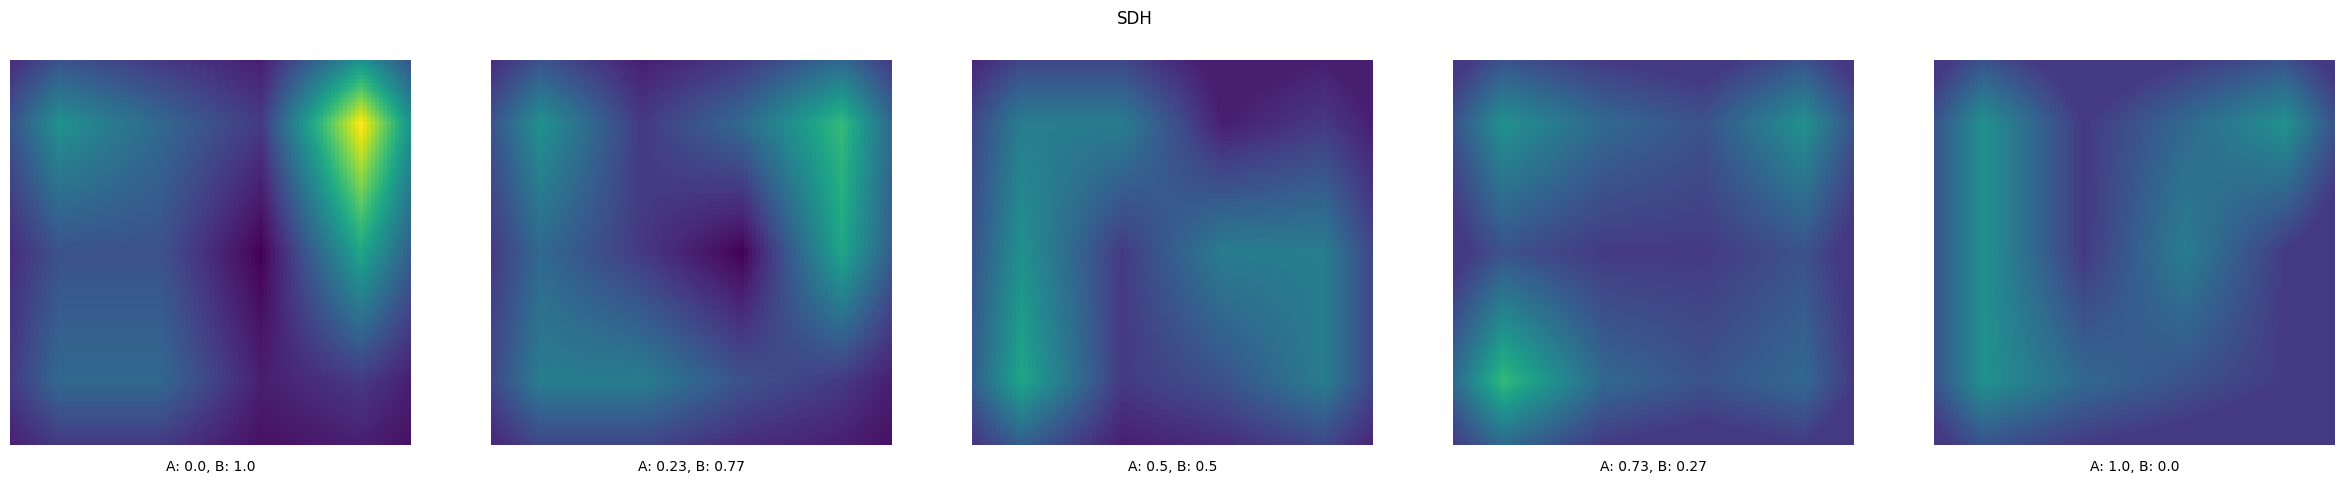

In [6]:
fig = plot_aligned_som(
    asom, data,
    visualization_function=SDH,
    num_plots=5,
    upscaling_factor=100,
    factor=2)

### U-Matrix

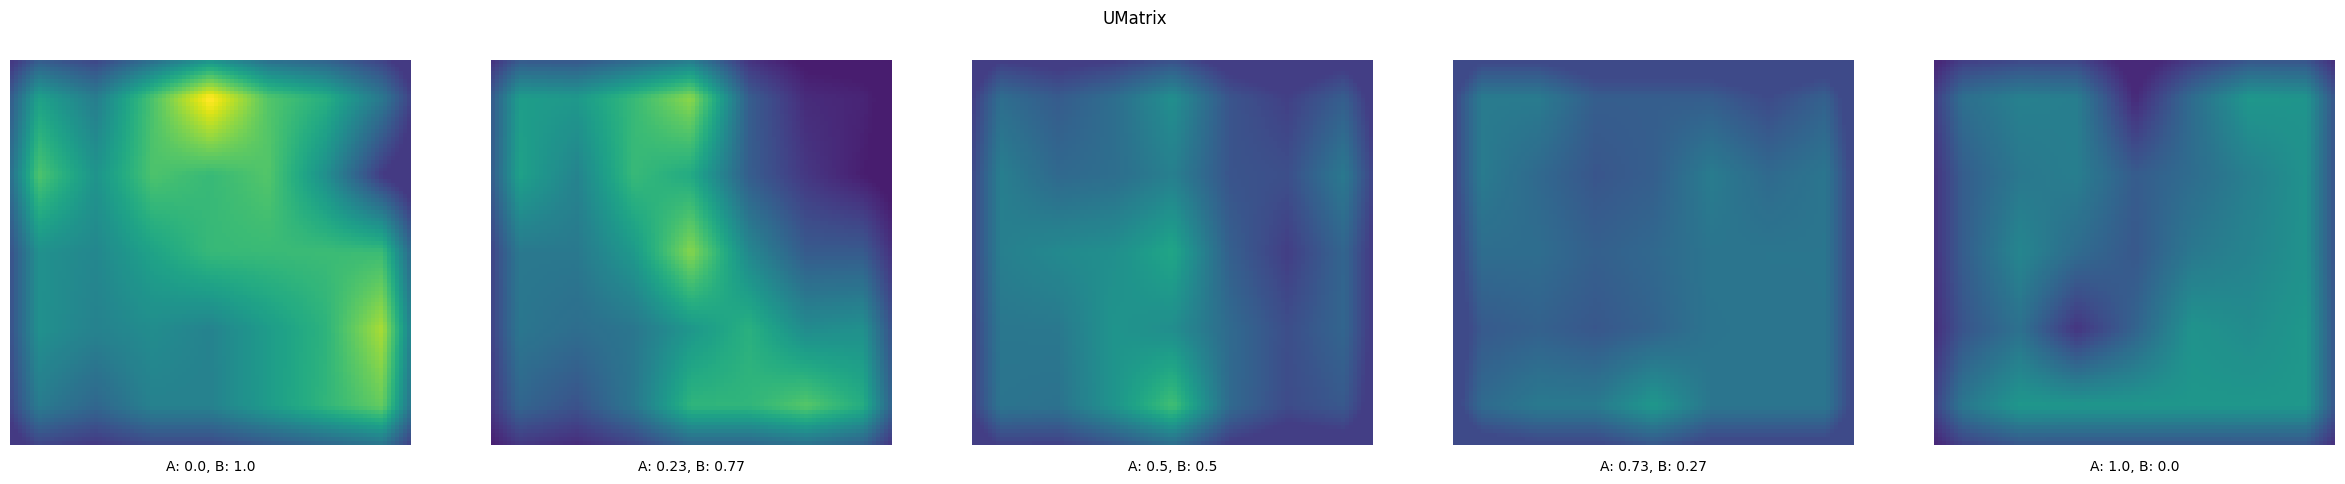

In [7]:
fig = plot_aligned_som(
    asom, data,
    visualization_function=UMatrix,
    num_plots=5,
    upscaling_factor=100)

### Hit Histogram

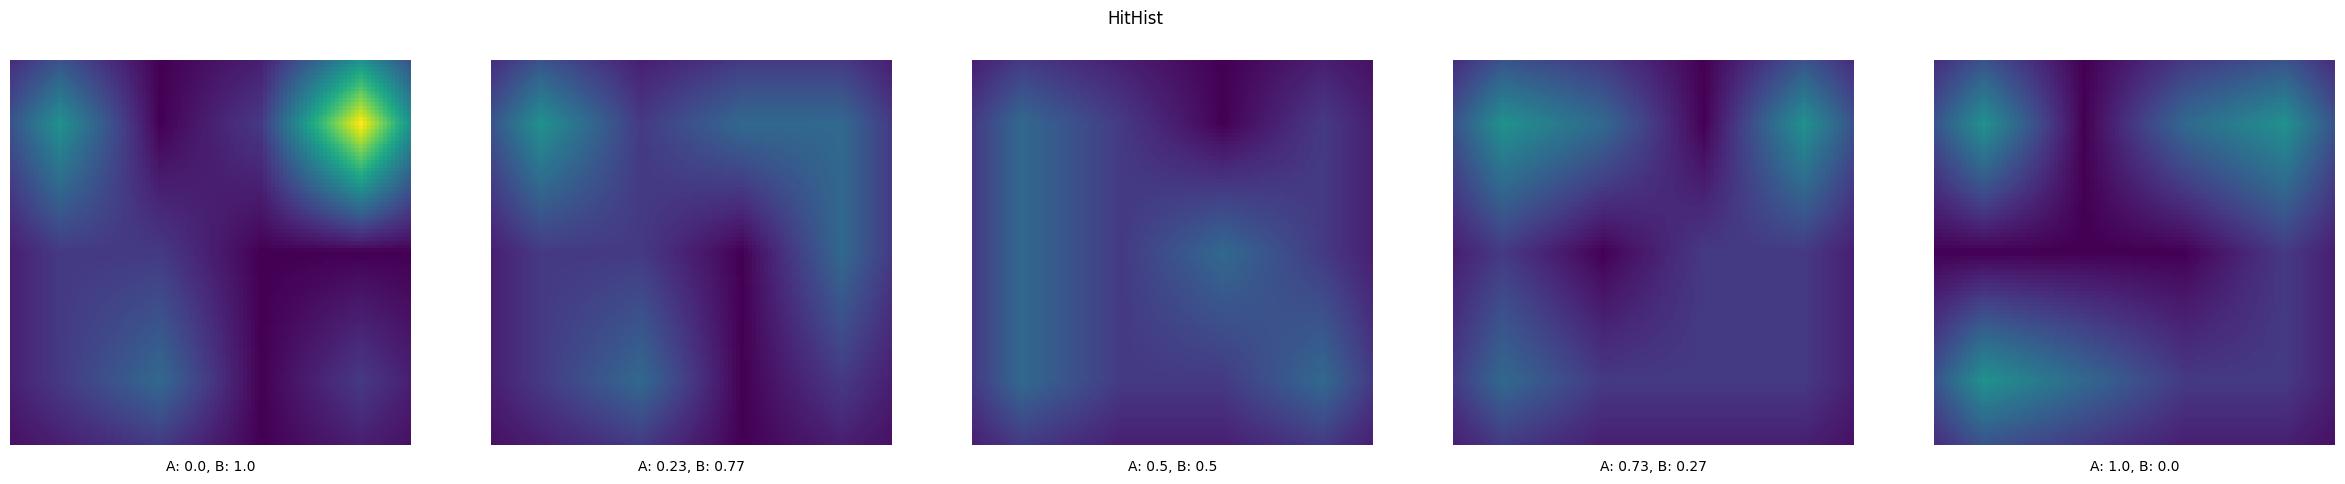

In [8]:
fig = plot_aligned_som(
    asom, data,
    visualization_function=HitHist,
    num_plots=5,
    upscaling_factor=100)